In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import glob
import pickle
from astropy.table import Table
import lmfit
from lmfit.models import VoigtModel
from scipy.interpolate import interp1d
from PyAstronomy import pyasl

import sys
from tqdm import tqdm
sys.path.append('../../../wdtools/')
sys.path.append('../../../../isochrones/')
from astropy.io import fits
import scipy
#plt.style.use('vedant')
from bisect import bisect_left
import lmfit
import isochrones
import wdtools
import matplotlib.gridspec as gridspec
sp = wdtools.SpecTools()
from scipy.ndimage import gaussian_filter

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

na1 = 5889.6
na2 = 5895.7

mg = 5176.7

ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.58

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import LinearNDInterpolator as lndi

Holoviews not imported. Some visualizations will not be available.
Using TensorFlow backend.
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

## Build sdA Interpolator

In [2]:
with fits.open('../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits') as f:
    phx_wav = f[0].data

In [64]:
def get_spectrum(source_id):
    path = '../../spec/'+str(source_id)+'_spec_0.fits'
    try:
        with fits.open(path) as f:
            flux = f[1].data['flux']
            loglam = f[1].data['loglam']
            fluxsig = f[1].data['ivar']
            lam = 10**loglam
            f.close()
    except:
        #raise FileNotFoundError('Spectrum file missing...')
        return np.nan, np.nan
    ## RV Correction and Interpolation
    
    return lam, flux

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

n_points = 10000
lamgrid = np.linspace(3100, 11500, n_points)

def get_sda(teff, logg, alpha = 0):
    
    alpha = str(alpha).replace('-', 'm')
    
    sda_files = np.array(glob.glob('../../phoenix/'+ alpha + '/*'))

    sda_teffs = np.array([int(sda_files[ii].split('-')[0][-5:]) for ii in range(len(sda_files))])
    sda_loggs = np.array([float(sda_files[ii].split('-')[1]) for ii in range(len(sda_files))])
    
    
    selection = (sda_teffs == teff) * (sda_loggs == logg)
    if np.sum(selection) != 1:
        print('finding nearest')
        teff = find_nearest(sda_teffs, teff)
        logg = find_nearest(sda_loggs[sda_teffs == teff], logg)
        logg = find_nearest(sda_loggs, logg)
        selection = (sda_teffs == teff) * (sda_loggs == logg)
    
    file = sda_files[selection][0]
    
    if alpha == '0':
        wl = np.linspace(3000, 10000, 70000) ## DONT CHANGE THIS! 
    elif alpha == 'm0.4':
        wl = phx_wav
        
    with fits.open(file) as f:
        fl = f[0].data
        
    
    func = interp1d(wl, fl, fill_value = 'extrapolate', kind = 'previous')
    fl = func(lamgrid)
    wl = lamgrid
    
    resolution = 0 #angstrom
    
    ang_in_wl = wl[1] - wl[0]
    filt = resolution / ang_in_wl
    
    fl = gaussian_filter(fl, int(filt))
        
    return wl, fl

In [65]:
alpha = '0'
sda_files = np.array(glob.glob('../../phoenix/'+ alpha + '/*'))

sda_teffs = np.array([int(sda_files[ii].split('-')[0][-5:]) for ii in range(len(sda_files))])
sda_loggs = np.array([float(sda_files[ii].split('-')[1]) for ii in range(len(sda_files))])

sda_teffs = sda_teffs[sda_loggs >= 2]
sda_loggs = sda_loggs[sda_loggs >= 2]

#plt.scatter(sda_teffs, sda_loggs)

In [66]:
teffs = np.sort(sda_teffs[sda_loggs == 4.5])
loggs = np.sort(sda_loggs[sda_teffs == 4000])

In [67]:
X, Y, Z = np.meshgrid(teffs, loggs, np.log10(lamgrid))

vals = np.zeros(X.shape)

In [68]:
for ii in range(vals.shape[0]):
    for jj in range(vals.shape[1]):
        wl, fl =  get_sda(X[ii, jj, 0], Y[ii, jj, 0])
        for kk in range(vals.shape[2]):
            vals[ii, jj, kk] = np.log10(fl[kk])

finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest
finding nearest


In [69]:
interpsda = rgi(points = [loggs, teffs, np.log10(lamgrid)], values = vals)

pickle.dump(interpsda, open('interp/interpsda.p', 'wb'))

In [70]:
def interp_sda(teff, logg, wl):
    return 10**interpsda((logg, teff, np.log10(wl)))

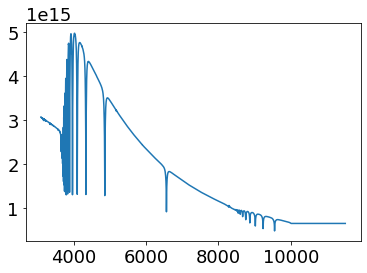

In [71]:
plt.plot(lamgrid, interp_sda(8000, 5.0, lamgrid))

## Build WD Interpolator

In [16]:
sys.path.append('../../../')
import WD_models
fontaine_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**fontaine_model['logg'])/100

rsun = np.sqrt(fontaine_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun

logg_teff_to_rsun = WD_models.interp_xy_z_func(x = fontaine_model['logg'], y = 10**fontaine_model['logteff'],\
                                                z = rsun, interp_type = 'linear')

### Cool Models (Blouin et al. 2020)

In [17]:
wd_files = glob.glob('../../blouin/*')

wd_fls = [];
wd_teffs = [];
wd_loggs = [];
wd_wls = [];

for filename in tqdm(wd_files):
    logg = int(filename.split('/')[3][:3])/100

    f = open(filename)

    lines = f.readlines()

    wl = [];
    for line in lines[1:406]:
        wl_seg = [float(jj) for jj in line.split()]
        wl.extend(wl_seg)

    wl = np.asarray(wl)[24:]

    for line in (lines[406:]):
        idx = lines.index(line) + 5
        if line.split()[0] == 'Effective':
            teff = float(line.split()[3])
            fl = [];
            for subline in lines[idx:(idx+670)]:
                fl_seg = [float(jj) for jj in subline.split()]
                fl.extend(fl_seg)

            fl = np.asarray(fl)
            wd_fls.append(fl)
            wd_teffs.append(teff)
            wd_loggs.append(logg)
            wd_wls.append(wl)

wd_fls = np.asarray(wd_fls)
wd_wls = np.asarray(wd_wls)
wd_loggs = np.asarray(wd_loggs)
wd_teffs = np.asarray(wd_teffs)

100%|██████████| 11/11 [00:26<00:00,  2.39s/it]


In [18]:
n_points = 10000
lamgrid = np.linspace(2000, 11000, n_points)

def get_wd(teff, logg):
    
    idx = (wd_teffs == teff) * (wd_loggs == logg)
    
    if np.sum(idx) != 1:
        print('not found')
        return None

    wl = wd_wls[idx][0]
    
    fl = wd_fls[idx][0]
    
    func = interp1d(wl, fl)
    fl = func(lamgrid)
    wl = lamgrid
    
    #fl = fl * speed_light / (wl)**2
    
    return wl, fl 

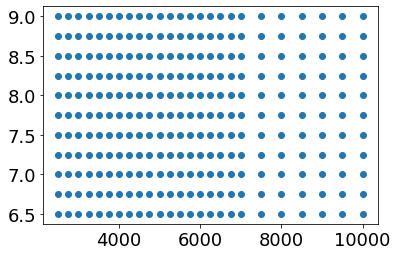

In [19]:
plt.scatter(wd_teffs, wd_loggs)

In [20]:
teffs = np.sort(wd_teffs[wd_loggs == 8])
loggs = np.sort(wd_loggs[wd_teffs == 4000])

In [21]:
X, Y, Z = np.meshgrid(teffs, loggs, np.log10(lamgrid))

vals = np.zeros(X.shape)

In [22]:
for ii in range(vals.shape[0]):
    for jj in range(vals.shape[1]):
        wl, fl =  get_wd(X[ii, jj, 0], Y[ii, jj, 0])
        for kk in range(vals.shape[2]):
            vals[ii, jj, kk] = np.log10(fl[kk])

In [23]:
interpwd = rgi(points = [loggs, teffs, np.log10(lamgrid)], values = vals)

pickle.dump(interpwd, open('interp/interpwd.p', 'wb'))